In [1]:
import tkinter as tk
import json
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Implement the default Matplotlib key bindings.
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,)
from matplotlib.figure import Figure


d:\anaconda\envs\gempy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Not subsurface compatibility available


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def combine_funcs(*funcs): 
  
    # this function will call the passed functions 
    # with the arguments that are passed to the functions 
    def inner_combined_func(*args, **kwargs): 
        for f in funcs: 
  
            # Calling functions with arguments, if any 
            f(*args, **kwargs) 
  
    # returning the reference of inner_combined_func 
    # this reference will have the called result of all 
    # the functions that are passed to the combined_funcs 
    return inner_combined_func 

In [3]:
def set_layer_name():
    for i in range(int(layer_number_entry.get())):
        tk.Label(root, text="Layer " + str(i+1) + " name:").grid(row=i+1, column=0)

        
        layer_name = f'Layer {str(i+1)} name'
        name[layer_name] = tk.Entry(root)
        name[layer_name].grid(row=i+1, column=1)

    tk.Button(root, text="OK",command=combine_funcs(save_name,set_draw)).grid(row=i+2, column=1)

In [4]:
def save_name():
    for i in range(int(layer_number_entry.get())):
        name_saved.append(name[f'Layer {str(i+1)} name'].get())

In [5]:
def draw_X():
    %run draw.py

    # Read points from the JSON file
    with open("curve_points.json", "r") as file:
        points = json.load(file)
    slice_x = np.array(points)[0]
    x_points.append(slice_x)

    a = int(layer_number_entry.get())

    fig = Figure(figsize = (5,4), dpi = 100)
    ax = fig.add_subplot()

    # ax.plot(slice_x[:, 0], slice_x[:, 1], "-")
    for i in range(np.array(x_points).shape[0]):
        ax.plot(np.array(x_points)[i][:, 0], np.array(x_points)[i][:, 1], "-")
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 600)
    ax.grid()
    ax.invert_yaxis()
    line = FigureCanvasTkAgg(fig, master = root)   
    line.draw()
    line.get_tk_widget().grid(row=a+3, column=5)

In [6]:
def draw_Y():
    %run draw.py

    # Read points from the JSON file
    with open("curve_points.json", "r") as file:
        points = json.load(file)
    slice_y = np.array(points)[0]
    y_points.append(slice_y)

    a = int(layer_number_entry.get())

    fig = Figure(figsize = (5,4), dpi = 100)
    ax = fig.add_subplot()
    # ax.plot(slice_y[:, 0], slice_y[:, 1], "-")
    for i in range(np.array(y_points).shape[0]):
        ax.plot(np.array(y_points)[i][:, 0], np.array(y_points)[i][:, 1], "-")
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 600)
    ax.grid()
    ax.invert_yaxis()
    line = FigureCanvasTkAgg(fig, master = root)   
    line.draw()
    line.get_tk_widget().grid(row=a+3, column=6)

  

In [7]:
def set_draw():
    for i in range(int(layer_number_entry.get())):

        tk.Button(root, text="Please draw " + "Layer " + str(i+1) + "X cross-section",command=draw_X).grid(row=i+1, column=2)
        tk.Button(root, text="Please draw " + "Layer " + str(i+1) + "Y cross-section",command=draw_Y).grid(row=i+1, column=3)

    tk.Button(root, text="Create model!",command=root.destroy).grid(row=0, column=4)
 

In [8]:
def surface_all():

    surface_all = pd.DataFrame(columns=('X','Y','Z','formation'))
    for i in range(np.array(x_points).shape[0]):
        slice_x = np.array(x_points)[i]
        slice_y = np.array(y_points)[i]
        slice_x_max = np.array([slice_x[:,0][slice_x[:,1]==slice_x[:,1].min()][0], slice_x[:,1].min()])
        slice_y_max = np.array([slice_y[:,0][slice_y[:,1]==slice_y[:,1].min()][0], slice_y[:,1].min()])

        diff = slice_x_max - slice_y_max
        slice_y[:,1] = slice_y[:,1] + diff[1]

        x_slice = [slice_x[:,0],
                    np.ones(len(slice_x))*slice_y_max[0],
                -slice_x[:,1]]
        x_slice = pd.DataFrame((np.array(x_slice).T),columns=('X','Y','Z'))

        y_slice = [np.ones(len(slice_y))*slice_x_max[0],
                slice_y[:,0],
                -slice_y[:,1]]
        y_slice = pd.DataFrame((np.array(y_slice).T),columns=('X','Y','Z'))

        formation = pd.DataFrame(data={'formation':[name_saved[i]]*(len(x_slice) + len(y_slice))})

        surface = pd.concat([pd.concat([x_slice,y_slice],ignore_index=True),formation],axis=1)

        surface_all = pd.concat([surface_all,surface],ignore_index=True)
    return surface_all



In [9]:
# calculate the orientation of the cross-section
def cal_orientation(x,y):
    x1 = y[1]-x[1]
    y1 = y[0]-x[0]
    
    return x1/np.sqrt(x1**2+y1**2), y1/np.sqrt(x1**2+y1**2)


In [10]:
def create_model():
    surface_points = surface_all()
    geo_model = gp.create_model('salt')
    gp.init_data(geo_model, [0, 800, 0, 800, -600, 0], [50, 50, 50],
            surface_points_df = surface_points,
            default_values=False)
    geo_model.add_surfaces('basement')

    # for i in result:
    #     gp.set_orientation_from_surface_points(geo_model, np.array([i[0],i[1],i[2]]))
    # geo_model.set_default_orientation()
    # geo_model.add_orientations(slice_x_max[0],slice_y_max[0],-slice_x_max[1], surface ='salt',pole_vector =[0,0,1], orientation=[0,0,1])

#     geo_model.add_orientations(slice_x[10][0],slice_y_max[0],-slice_x[10][1], surface ='salt',pole_vector =[slice_x[11][1]-slice_x[10][1],0,slice_x[11][0]-slice_x[10][0]])

    #add orientations
    # Sample array

    for n in range(np.array(x_points).shape[0]):

        slice_x = np.array(x_points)[n]
        slice_y = np.array(y_points)[n]

        slice_x_max = np.array([slice_x[:,0][slice_x[:,1]==slice_x[:,1].min()][0], slice_x[:,1].min()])
        slice_y_max = np.array([slice_y[:,0][slice_y[:,1]==slice_y[:,1].min()][0], slice_y[:,1].min()])

        diff = slice_x_max - slice_y_max
        slice_y[:,1] = slice_y[:,1] + diff[1]
        
        array = list(range(slice_x.shape[0]))  

        # List to store the result
        result_1 = []

        # Iterate through the array to select 3 continuous numbers
        for i in range(len(array)-1):
            # Select three continuous numbers and add them to the result list
            triplet = (array[i], array[i +1])
            result_1.append(triplet)

        array = list(range(slice_y.shape[0]))  # Creates a list from 0 to 100

        # List to store the result
        result_2 = []

        # Iterate through the array to select 3 continuous numbers
        for i in range(len(array)-1):
            # Select three continuous numbers and add them to the result list
            triplet = (array[i], array[i +1])
            result_2.append(triplet)


        for i in result_1:
            geo_model.add_orientations(slice_x[i[0]][0],slice_y_max[0],-slice_x[i[0]][1], surface =name_saved[n],pole_vector =[cal_orientation(slice_x[i[0]],slice_x[i[1]])[0],0,cal_orientation(slice_x[i[0]],slice_x[i[1]])[1]])

        for i in result_2:
            geo_model.add_orientations(slice_x_max[0],slice_y[i[0]][0],-slice_y[i[0]][1], surface =name_saved[n],pole_vector =[0,cal_orientation(slice_y[i[0]],slice_y[i[1]])[0],cal_orientation(slice_y[i[0]],slice_y[i[1]])[1]])

    #plot results
    gp.plot_2d(geo_model, plotter_type='basic',show_data=True,legend=False,direction='y')
    gp.plot_2d(geo_model, plotter_type='basic',show_data=True,legend=False,direction='x')
    # gpv = gp.plot_3d(geo_model, image=True, plotter_type='basic',show_data=True)

    return geo_model

pygame 2.4.0 (SDL 2.26.4, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\jya\AppData\Local\Temp\ipykernel_23152\2450222223.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i in range(np.array(x_points).shape[0]):
C:\Users\jya\AppData\Local\Temp\ipykernel_23152\2450222223.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(x_points)[i][:, 0], np.array(x_points)[i][:, 1], "-")
C:\Users\jya\AppData\Local\Temp\ipykernel_23152\2092033164.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different le

Active grids: ['regular']


C:\Users\jya\AppData\Local\Temp\ipykernel_23152\4143648538.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for n in range(np.array(x_points).shape[0]):
C:\Users\jya\AppData\Local\Temp\ipykernel_23152\4143648538.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  slice_x = np.array(x_points)[n]
C:\Users\jya\AppData\Local\Temp\ipykernel_23152\4143648538.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

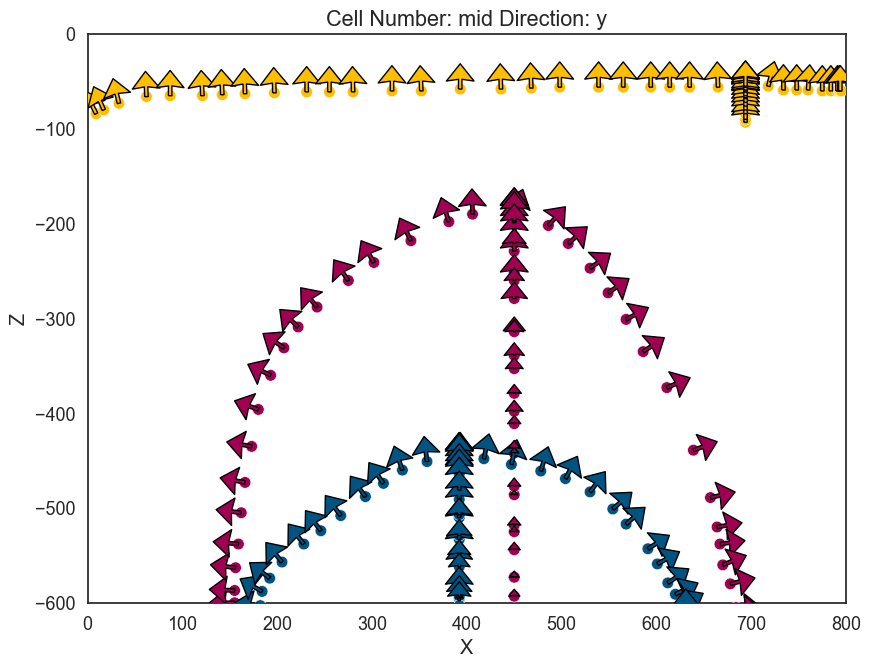

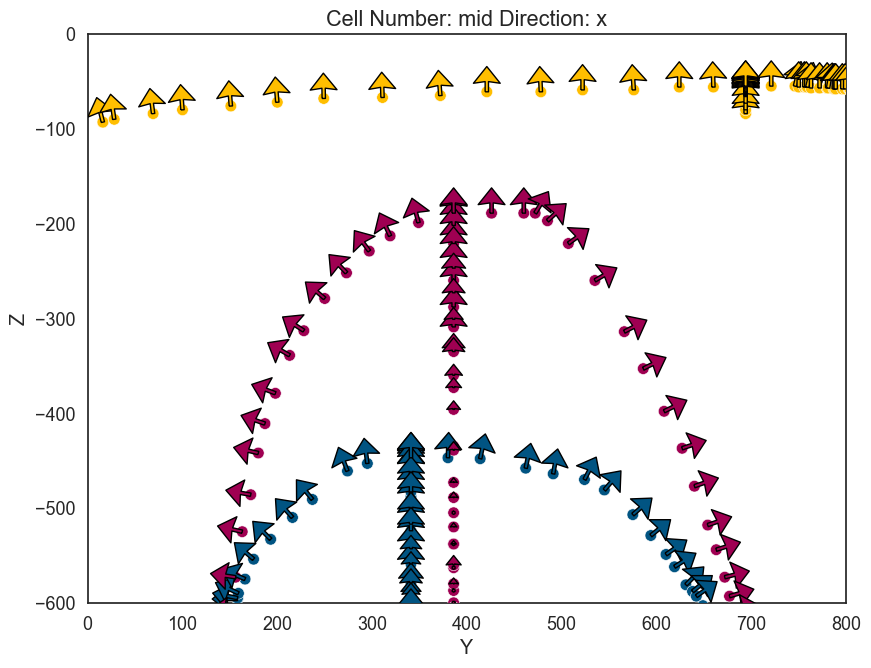

In [11]:
root = tk.Tk()
root.geometry("1920x1080")
name = {}
name_saved = []
x_points = []
y_points = []
Layer_number_label = tk.Label(root,text="Please enter the layer number:")
layer_number_entry = tk.Entry(root)
layer_number_confirm = tk.Button(root,text="confirm",command=set_layer_name)

Layer_number_label.grid(row=0,column=0)
layer_number_entry.grid(row=0,column=1)
layer_number_confirm.grid(row=0,column=2)
root.mainloop()

geo_model = create_model()

Setting kriging parameters to their default values.
Compiling theano function...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '660' (I am process '23152')
d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file sc

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range             1280.624847
$C_o$            39047.619048
drift equations           [3]


d:\anaconda\envs\gempy\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
d:\anaconda\envs\gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


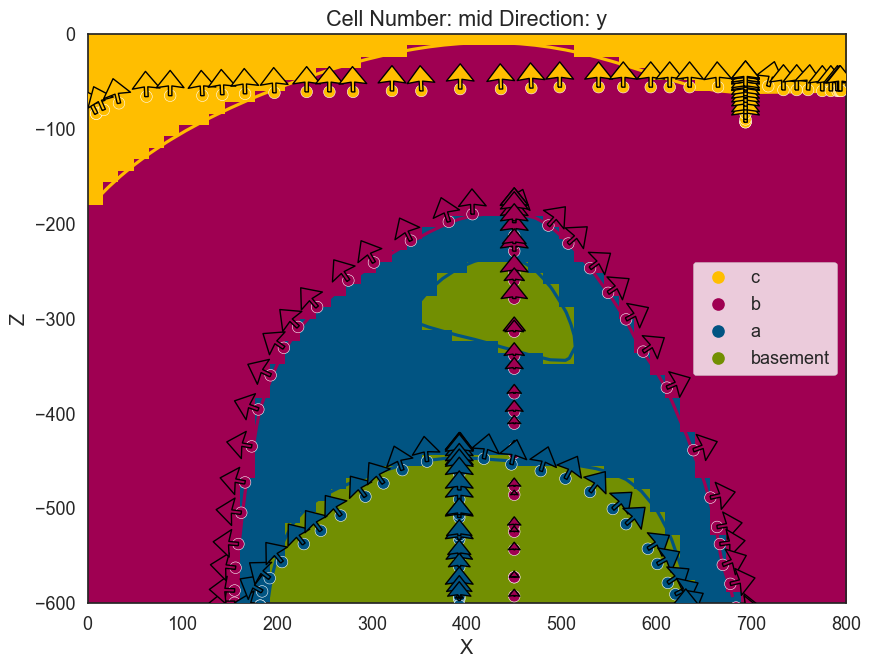

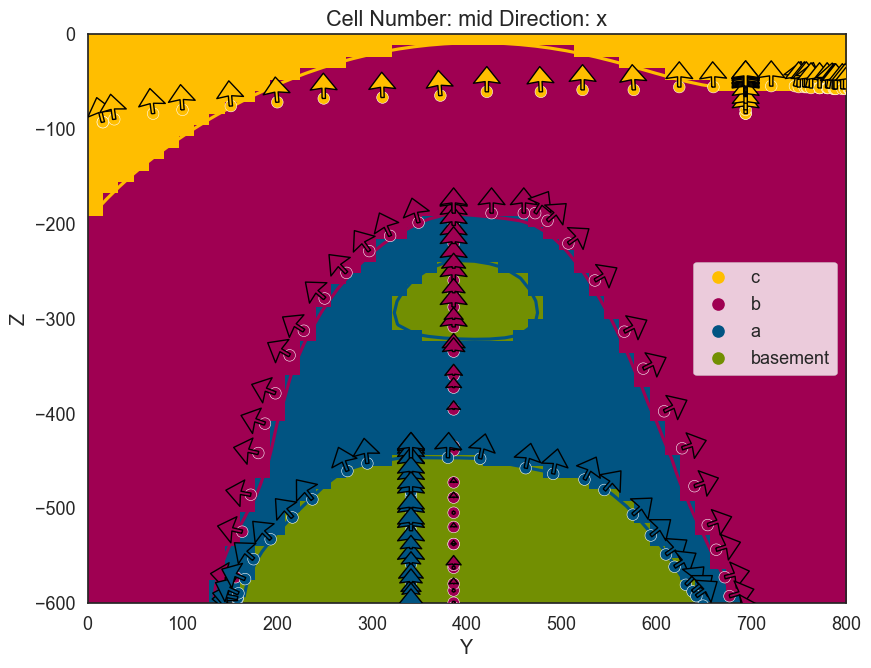

In [12]:
gp.set_interpolator(geo_model,
            compile_theano=True,
            theano_optimizer='fast_compile',
            )
sol = gp.compute_model(geo_model)
gp.plot_2d(geo_model, show_data=True,direction='y')
gp.plot_2d(geo_model, show_data=True,direction='x')
plt.show()

In [14]:
gpv = gp.plot_3d(geo_model, image=False, plotter_type='basic',show_data=1)